# Testing different approaches for training an agent playing Tic-Tac-Toe

In [5]:
!git clone https://github.com/KunkelAlexander/tictactoe_rl.git

fatal: destination path 'tictactoe_rl' already exists and is not an empty directory.


In [6]:
from tictactoe_rl.src.tictactoe import TicTacToe
from tictactoe_rl.src.game_manager import GameManager
from tictactoe_rl.src.training_manager import TrainingManager

from tictactoe_rl.src.gui import ascii_gui

training_manager = TrainingManager( game = TicTacToe(board_size  = 3, agent_count = 2),
                                    gui  = ascii_gui)

base_config = {
    "agent_types"         : ["RANDOM_AGENT", "RANDOM_AGENT"],
    "board_size"          : 3,
    "n_episode"           : 10000,  # Number of training episodes
    "n_eval"              : 100,    # Number of evaluation episodes every eval_freq training episodes
    "eval_freq"           : 100,
    "train_freq"          : 100,    # Train models every train_freq training episodes
    "discount"            : 0.95,   # Discount in all Q learning algorithms
    "learning_rate_decay" : 1,
    "exploration"         : 0.2,    # Initial exploration rate
    "exploration_decay"   : 1-1e-3, # Decrease of exploration rate for every action
    "exploration_min"     : 0.05,
    "learning_rate"       : 1e-2,
    "randomise_order"     : False,  # Randomise starting order of agents for every game
    "only_legal_actions"  : True,   # Have agents only take legal actions
    "debug"               : False,  # Print loss and evaluation information during training
    "batch_size"          : 1024,   # Batch size for DQN algorithm
    "replay_buffer_size"  : 5000,   # Replay buffer for DQN algorithm
    "target_update_tau"   : 1e-2,   # Weight for update in dual DQN architecture target = (1 - tau) * online + tau * target
    "initial_q"           : 0.6,    # Initial Q value for tabular Q learning
}

The TrainingManager class runs `n_episode` games (episodes), evaluates the agents every `eval_freq` episodes with `n_eval` games (without exploration and learning) and calls the respective agents' `train()` functions every `train_freq` episodes. In the end, it summarises the evaluation sequences with a plot and returns the trained agents as well as the evaluation data.
By default, we fix the order in which the agents play and only allow legal actions. In Q-learning, only the Q values for legal moves are updated in this case. Alternatively, invalid moves are punished with a negative reward.

## Games against agent playing random moves

We first establish the baseline performance of an agent taking random moves playing against itself, first against the deterministic minmax agent and second against the randomised minmax agent.

100%|██████████| 10/10 [01:08<00:00,  6.87s/it]


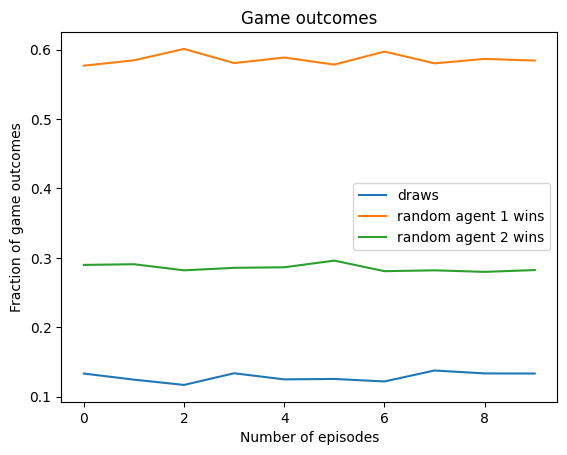

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
out_random = training_manager.run_training(config)

Playing first gives the random player an advantage of winning close to 60% of the games with around 15% draws.

Initializing MinMax agent 2


100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


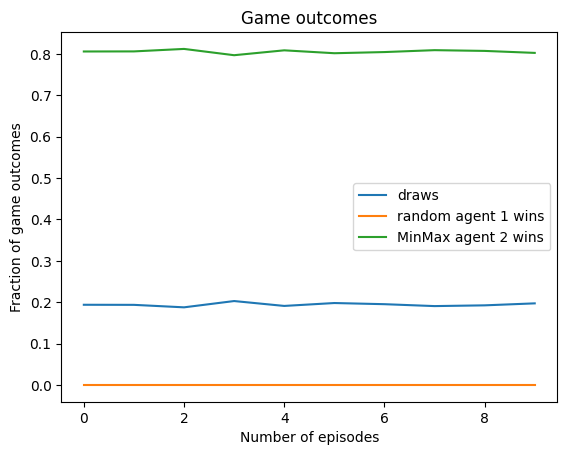

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "MINMAX_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
out_minmax = training_manager.run_training(config)

Playing first against the minmax agent, the random agent cannot win anymore, but still achieves around 20% of draws.

Initializing random MinMax agent 1


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


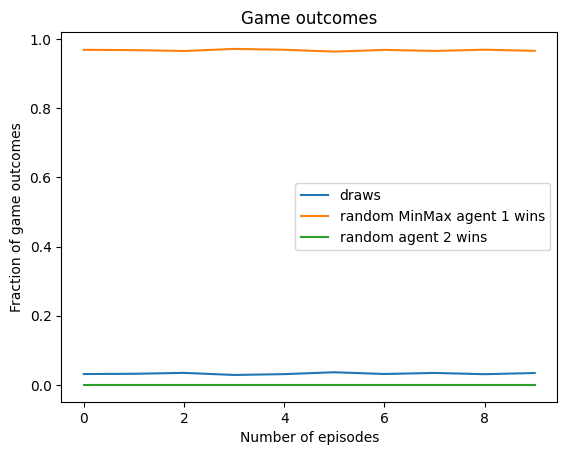

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
out_minmax = training_manager.run_training(config)

Playing second against the (random) minmax agent, the random agent only achieves < 10% draws and no victories.

## How do the results change if we allow invalid moves?
I would expect the match results between random agents to stay unchanged and the minmax agent to win close to 100% of games regardless of who begins.

100%|██████████| 10/10 [02:02<00:00, 12.22s/it]


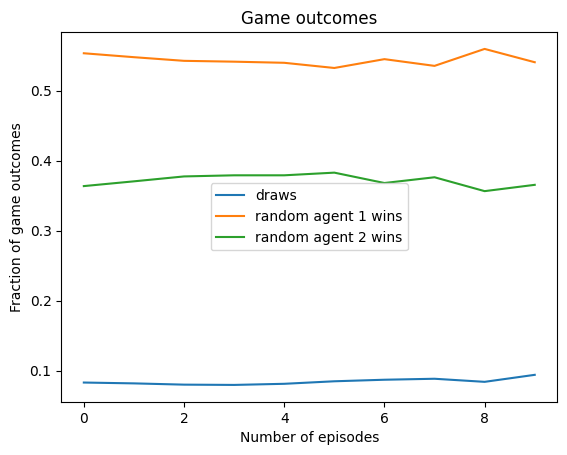

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
config["only_legal_actions"]  = False
out_random = training_manager.run_training(config)

Apparently, the chances of random agent 2 winning the game slightly increase when invalid actions are allowed. This is likely because the advantage of playing first is less relevant when both players lose tempi through invalid moves later in the game.

Initializing MinMax agent 2


100%|██████████| 10/10 [01:13<00:00,  7.32s/it]


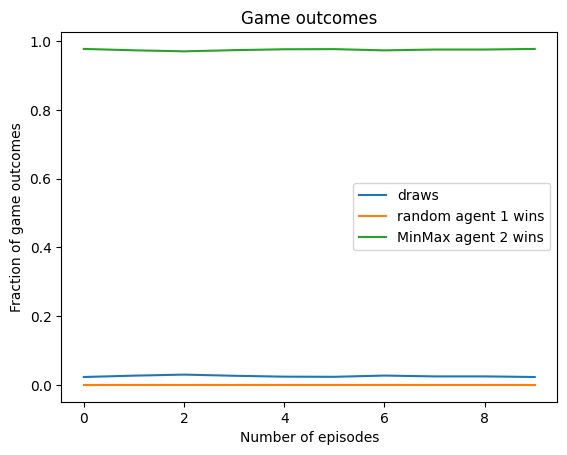

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "MINMAX_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
config["only_legal_actions"] = False
out_minmax = training_manager.run_training(config)

As expected, the random agent playing first against the minmax agent, plays less then 5% draws compared to 20% when it was forced to make valid moves.

Initializing random MinMax agent 1


100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


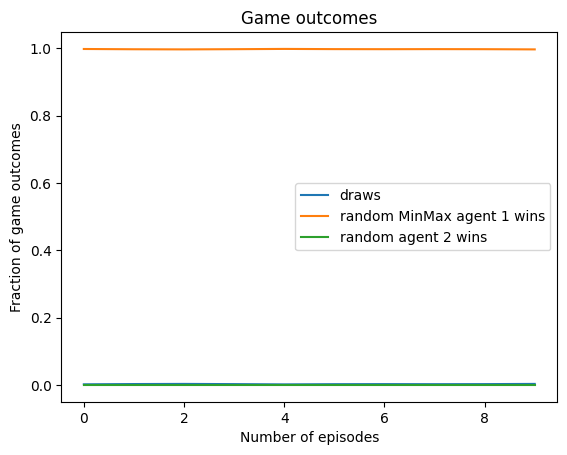

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
config["only_legal_actions"] = False
out_minmax = training_manager.run_training(config)

As expected, the random agent playing second against the minmax agent, plays close to zero draws.

## Games against the tabular Q-agent

The tabular Q agent uses a table keeping record of all $3^9$ possible game states and should in principle be able to learn an optimal policy against a given agent. The Q-table is updated after every episode. The learning rate is kept fixed and the exploration rate decreases to a minimum of 5% with every action taken.
The reward system is structured as follows in this and all the following Q learning approaches:
- victory:         1.0
- draw:            0.5
- loss:            0.0
- invalid action: -0.1

100%|██████████| 50000/50000 [04:28<00:00, 186.48it/s]


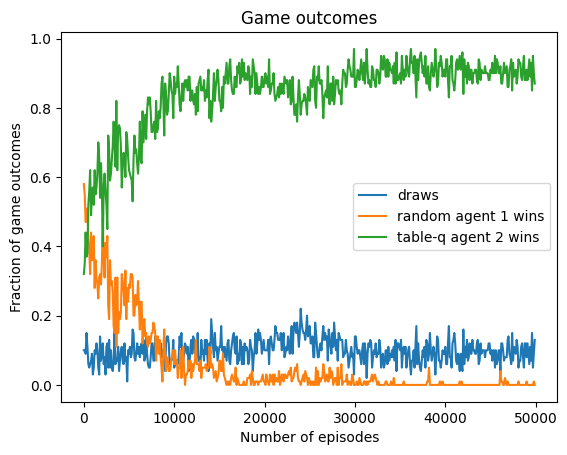

In [ ]:
config = dict(base_config)
config["agent_types"]         = ["RANDOM_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]           = 50000
config["eval_freq"]           = 100
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1-1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
_ = training_manager.run_training(config)

Interestingly, the tabular Q-learning approach achieves a higher victory rate against the random agent than the minmax agent. On the downside, it still occasionally loses games. This suggests that it learned a slightly more aggressive and riskier strategy than the minmax algorithm.

100%|██████████| 50000/50000 [05:01<00:00, 165.58it/s]


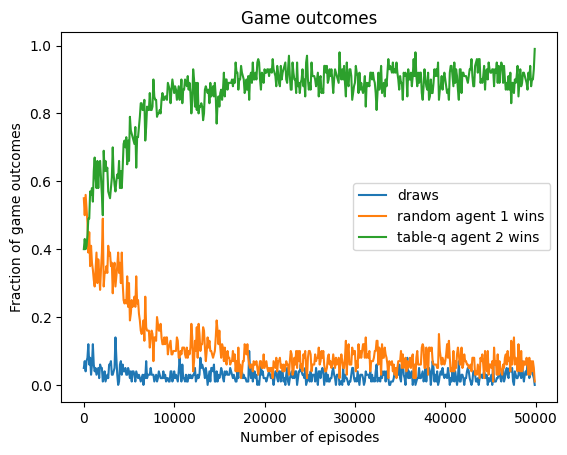

In [ ]:
config = dict(base_config)
config["agent_types"]         = ["RANDOM_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]           = 50000
config["eval_freq"]           = 100
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1-1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
config["only_legal_actions"]  = False
_ = training_manager.run_training(config)

If invalid actions are allowed, I would have expected the algorithm to take longer to converge to a good policy because it needs to see more episodes. Instead, the shape of the victory curve is similar to the case where it can only take legal actions from the start. However, it still loses a significant fraction of games even after 50000 episodes of training and performs worse than the agent that can only take valid actions.

Initializing random MinMax agent 1


100%|██████████| 50000/50000 [06:05<00:00, 136.76it/s]


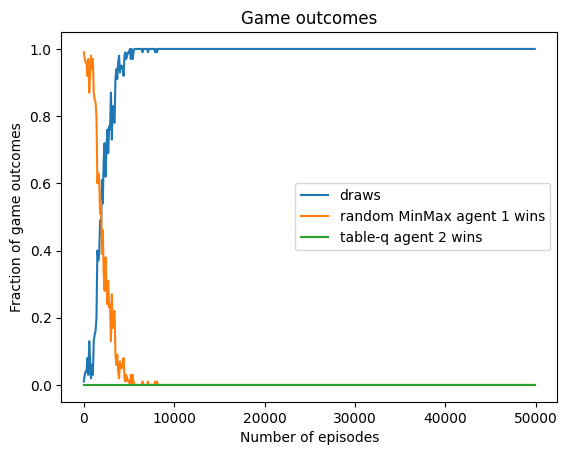

In [ ]:
config = dict(base_config)
config["agent_types"]         = ["RANDOM_MINMAX_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]           = 50000
config["eval_freq"]           = 100
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1-1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
_ = training_manager.run_training(config)

Playing second against the random minmax agent, the tabular Q learning algorithm quickly finds a policy that allows it to not lose any games.

Initializing random MinMax agent 1


100%|██████████| 50000/50000 [05:13<00:00, 159.73it/s]


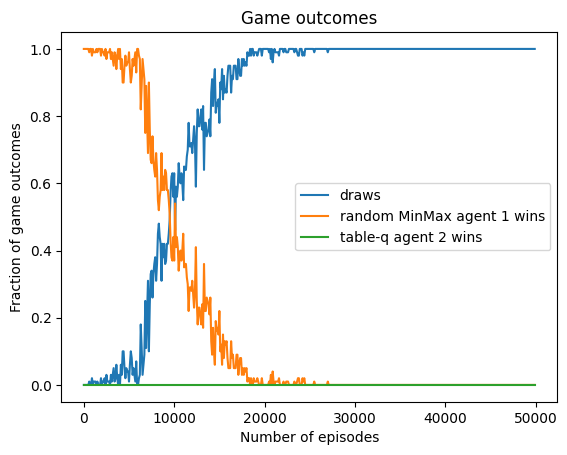

In [ ]:
config = dict(base_config)
config["agent_types"]         = ["RANDOM_MINMAX_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]           = 50000
config["eval_freq"]           = 100
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1-1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
config["only_legal_actions"]  = False
_ = training_manager.run_training(config)


When the tabular Q agent is allowed to make illegal moves, it takes longer to learn an optimal policy against the random minmax agent, but still does so after around 30000 episodes.

## Replacing the Q-table with a neural network
In the following, we test different approaches to replace the Q-table with a neural network using an experience replay buffer with random sampling of minibatches.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import tictactoe_rl.src.agent_deep_q as agent_deep_q
import tictactoe_rl.src.agent_random as agent_random
import tictactoe_rl.src.agent_minmax as agent_minmax

In the following, we test different network architectures and hyperparameters playing second against the random minmax agent.

In [ ]:

def build_simple_dqn_model(input_shape, num_actions, num_hidden_layers = 1, hidden_layer_size = 256):
    inputs       = tf.keras.layers.Input(shape=input_shape)
    hidden_layer = inputs
    for i in range(num_hidden_layers):
        hidden_layer = tf.keras.layers.Dense(hidden_layer_size, activation='relu')(hidden_layer)
    # Linear activation for predicting arbitrary real numbers (Q values)
    outputs = tf.keras.layers.Dense(num_actions, activation='linear')(hidden_layer)
    # Create the model
    return models.Model(inputs=inputs, outputs=outputs)

### One hidden layer with 256 neurons (no invalid actions)

100%|██████████| 1000/1000 [06:01<00:00,  2.76it/s]


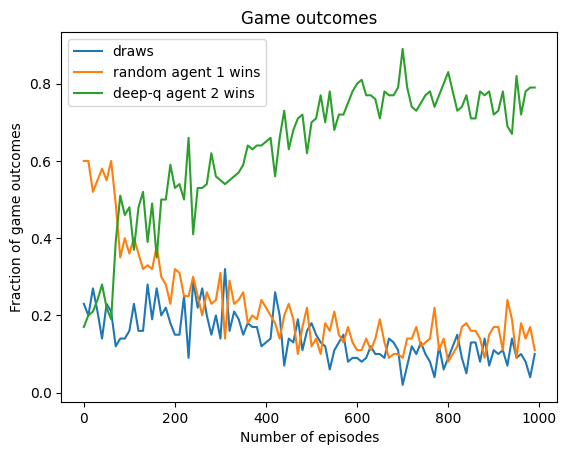

In [ ]:
config = dict(base_config)
config["n_episode"]         = 1000
config["n_eval"]            = 100
config["eval_freq"]         = 10
config["train_freq"]        = 1
config["exploration"]       = 0.8
config["exploration_decay"] = 1-1e-3
config["learning_rate"]     = 1e-2
config["batch_size"]        = 256
config["debug"]             = False
agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
agent2 = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

# Define the Q-Network
agent2.online_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions)
agent2.target_model = agent2.online_model

# Compile the model
agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[agent1, agent2])

The model, with some fine-tuning of the exploration achieves victory rates of roughly 70%-80% against the random agent after 1000 episodes of training. It still loses a substantial 20% of the games which shows that its performance is clearly worse than both the performance of the minmax and the tabular Q learning algorithms.

### One hidden layer with 256 neurons (invalid actions legal)

100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s]


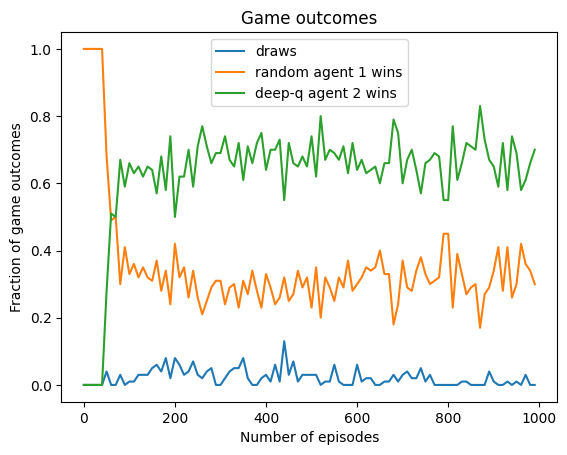

In [ ]:
config = dict(base_config)
config["n_episode"]          = 1000
config["n_eval"]             = 100
config["eval_freq"]          = 10
config["train_freq"]         = 1
config["exploration"]        = 0.8
config["exploration_decay"]  = 1-1e-3
config["learning_rate"]      = 1e-2
config["batch_size"]         = 256
config["debug"]              = False
config["only_legal_actions"] = False
agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
agent2 = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

# Define the Q-Network
agent2.online_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions)
agent2.target_model = agent2.online_model

# Compile the model
agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[agent1, agent2])

When allowing illegal actions, the performance of the model seemingly plateaus at around 70% victories with 30% losses. This compares to around 35% victories that the random agent achieved playing second against another random agent.

In the next step, we study whether a wider hidden layer and a deeper network can help improve the performance of the model.

### One layer with 512 neurons (no invalid actions)

100%|██████████| 2000/2000 [11:40<00:00,  2.86it/s]


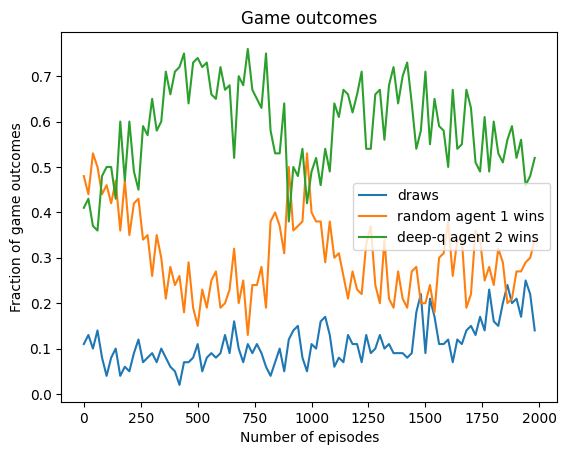

In [ ]:
config = dict(base_config)
config["n_episode"]         = 2000
config["n_eval"]            = 100
config["eval_freq"]         = 20
config["train_freq"]        = 1
config["exploration"]       = 0.8
config["exploration_decay"] = 1-1e-3
config["learning_rate"]     = 1e-2
config["batch_size"]        = 256
config["debug"]             = False
agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
agent2 = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

# Define the Q-Network
agent2.online_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions, hidden_layer_size=512)
agent2.target_model = agent2.online_model

# Compile the model
agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[agent1, agent2])

The performance of the model with a larger hidden layer is inferior to the model considered before. The training process also becomes unstable.

### Four layers with 32 neurons (no invalid actions)
We also slightly adjust the discount, the exploration rate and the replay buffer size.

100%|██████████| 1000/1000 [09:45<00:00,  1.71it/s]


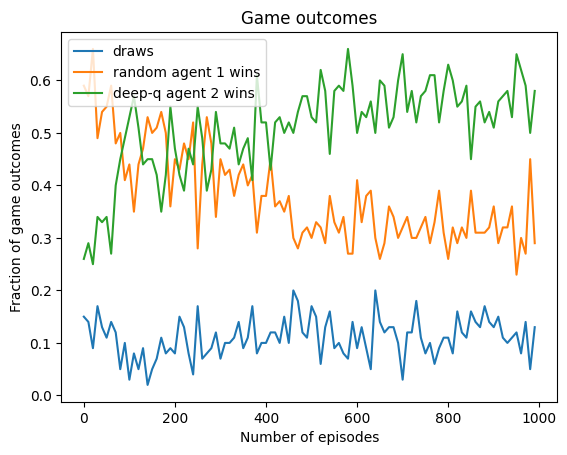

In [ ]:
config = dict(base_config)
config["n_episode"]          = 1000
config["n_eval"]             = 100
config["eval_freq"]          = 10
config["train_freq"]         = 1
config["discount"]           = 0.9
config["exploration"]        = 0.5
config["exploration_decay"]  = 1-1e-3
config["learning_rate"]      = 1e-2
config["batch_size"]         = 256
config["replay_buffer_size"] = 10000
config["debug"]              = False
agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
agent2 = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

# Define the Q-Network
agent2.online_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions, num_hidden_layers = 4, hidden_layer_size=32)
agent2.target_model = agent2.online_model

# Compile the model
agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[agent1, agent2])

A series of smaller layers also leads to decreased performance compared to a single layer with 256 neurons.

## Hyperparameter optimisation

### In the following, we check the impact of different learning rates, batch sizes and replay buffer sizes on the performance of the agent.

### Check different learning rates

100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]


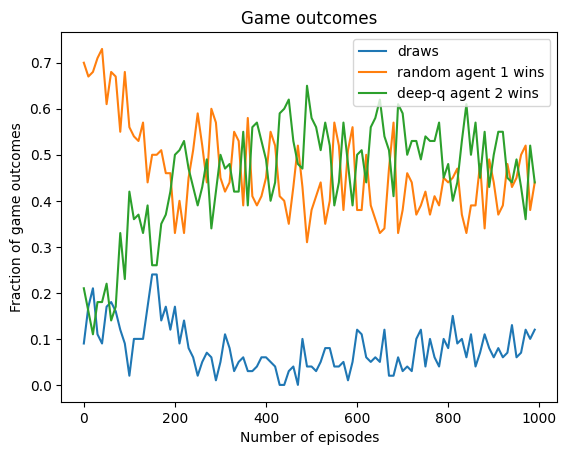

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


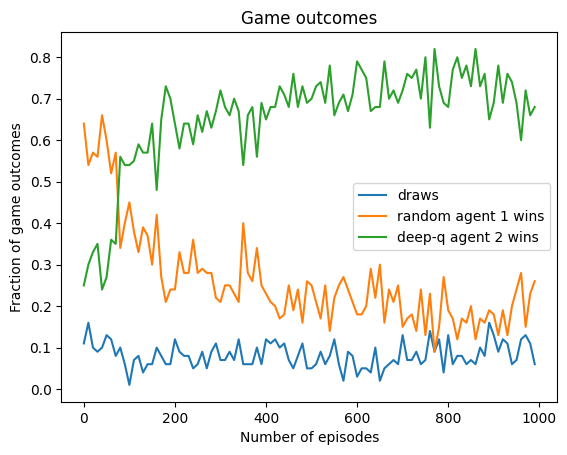

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


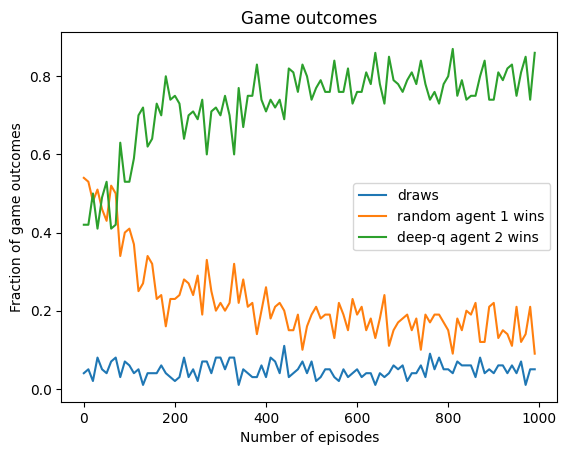

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


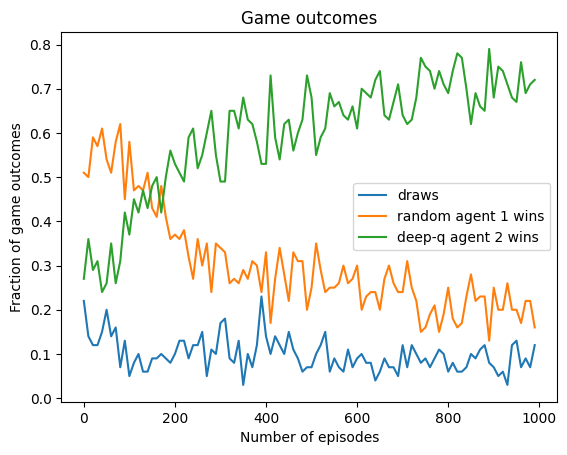

In [ ]:
config = dict(base_config)
config["n_episode"]         = 1000
config["n_eval"]            = 100
config["eval_freq"]         = 10
config["train_freq"]        = 1
config["exploration"]       = 0.8
config["exploration_decay"] = 1-1e-3
config["learning_rate"]     = 1e-2
config["batch_size"]        = 256
config["debug"]             = False

for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    config["learning_rate"] = lr
    agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
    agent2 = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

    # Define the Q-Network
    agent2.online_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions)
    agent2.target_model = agent2.online_model

    # Compile the model
    agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

    _ = training_manager.run_training(config, agents=[agent1, agent2])

The agent's performance is highest with a learning rate of $10^{-3}$ in the test run. While it plateaus after roughly 500 episodes however, the slightly less capable agent with a learning rate of $10^{-4}$ still shows signs of improving after 1000 episodes. In the following test, we set the learning rate to $5 \cdot 10^{-4}$ as a compromise and test different batch sizes.

In the next step, we are testing three different batch sizes.

100%|██████████| 1000/1000 [07:22<00:00,  2.26it/s]


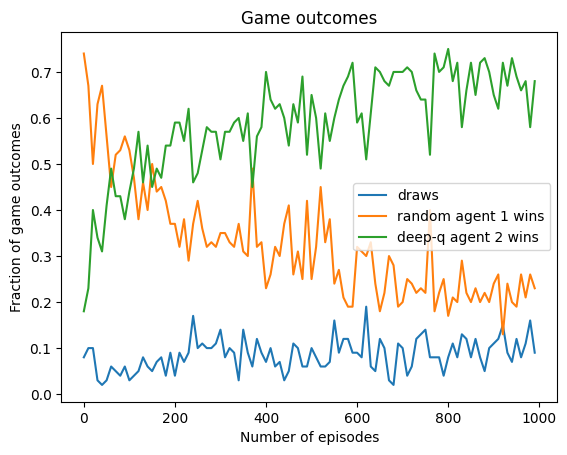

100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]


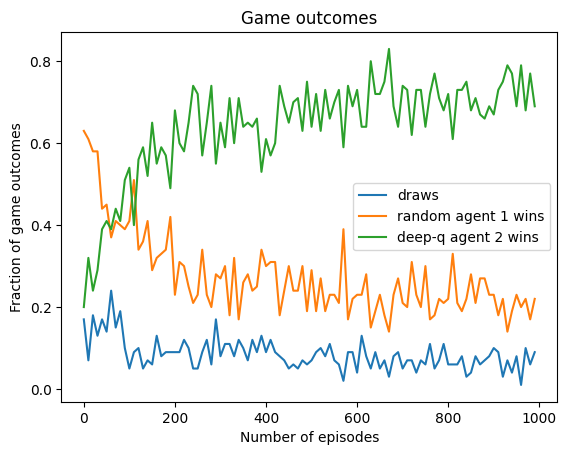

100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s]


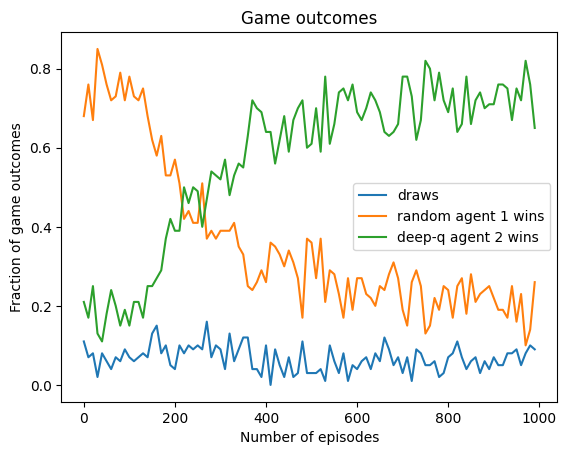

100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s]


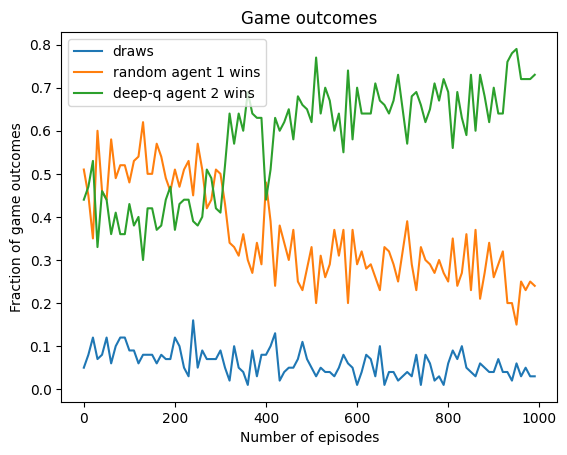

In [ ]:
config = dict(base_config)
config["n_episode"]          = 1000
config["n_eval"]             = 100
config["eval_freq"]          = 10
config["train_freq"]         = 1
config["exploration"]        = 0.8
config["exploration_decay"]  = 1-1e-3
config["learning_rate"]      = 5e-4
config["replay_buffer_size"] = 10000
config["debug"]              = False

for bs in [16, 64, 512, 1024]:
    config["batch_size"] = bs
    agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
    agent2 = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

    # Define the Q-Network
    agent2.online_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions)
    agent2.target_model = agent2.online_model

    # Compile the model
    agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

    _ = training_manager.run_training(config, agents=[agent1, agent2])

It seems that there is a tendency that larger batch sizes lead to better model performance.

### Test dual network architecture with target network

We now introduce a second NN. The so-called online network is used for predicting actions whereas the predictions of the so-called target network are used during training to predict the highest Q value of the next state in the Bellmann equation.
We compare two different update rates $\tau$ with the single-hidden layer model with $256$ neurons. During every training step, the weights of the target network are updates as
$$ w_{target} = (1 - \tau) \cdot w_{online} + tau \cdot w_{target}.$$
We use larger learning rates for the increased stability of the network makes it possible and because the training is slowed down too much otherwise according to my tests.

100%|██████████| 1000/1000 [10:05<00:00,  1.65it/s]


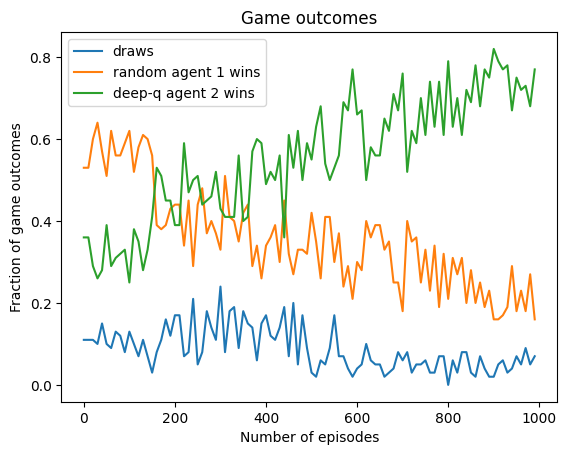

100%|██████████| 1000/1000 [10:28<00:00,  1.59it/s]


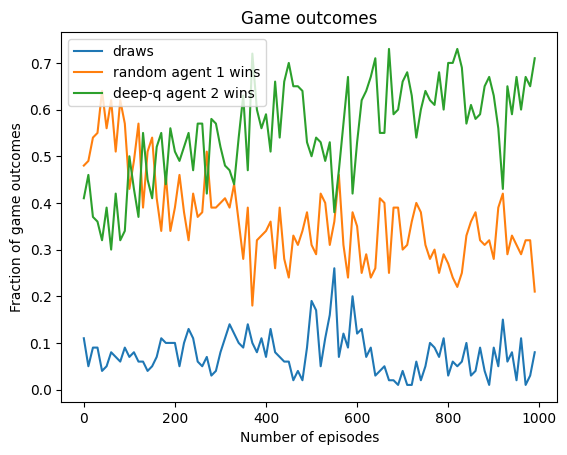

100%|██████████| 1000/1000 [10:23<00:00,  1.60it/s]


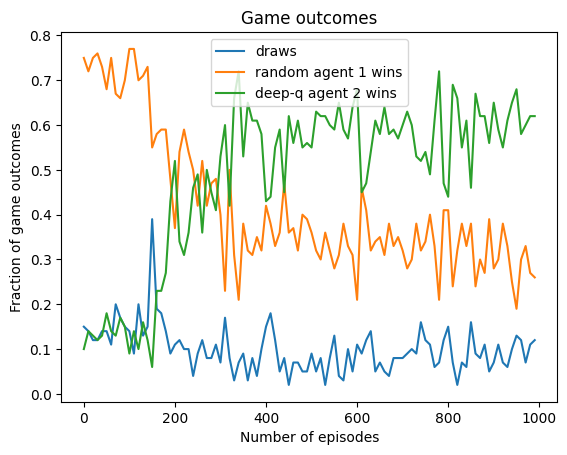

In [12]:
config = dict(base_config)
config["n_episode"]         = 1000
config["n_eval"]            = 100
config["eval_freq"]         = 10
config["train_freq"]        = 1
config["exploration"]       = 0.8
config["exploration_decay"] = 1-1e-3
config["learning_rate"]     = 5e-2
config["batch_size"]        = 512

for tau in [1e-1, 1e-2, 1e-3]:
    config["target_update_tau"] = tau
    agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
    agent2 = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

    # Define the Q-Network
    agent2.online_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions)
    agent2.target_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions)

    # Compile the model
    agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

    _ = training_manager.run_training(config, agents=[agent1, agent2])

We do not achieve higher performance in these test cases because the number of episodes is too low. We therefore double the number of episodes and check whether we can achieve higher peak performance with $\tau = 0.1$.

100%|██████████| 2000/2000 [21:34<00:00,  1.55it/s]


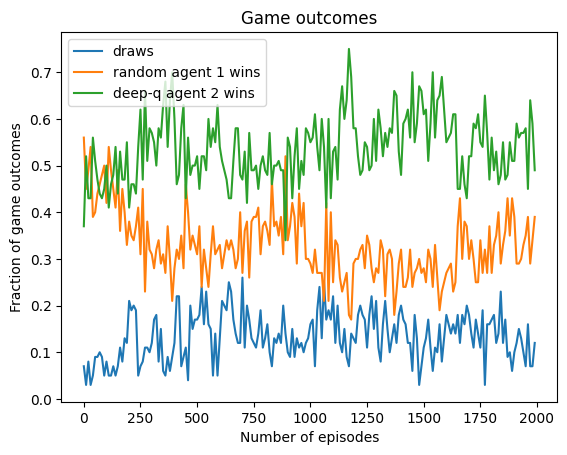

In [13]:
config = dict(base_config)
config["n_episode"]         = 2000
config["n_eval"]            = 100
config["eval_freq"]         = 10
config["train_freq"]        = 1
config["exploration"]       = 0.8
config["exploration_decay"] = 1-1e-3
config["learning_rate"]     = 5e-2
config["batch_size"]        = 512
config["target_update_tau"] = 0.1

agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
agent2 = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

# Define the Q-Network
agent2.online_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions)
agent2.target_model = build_simple_dqn_model(agent2.input_shape, agent2.n_actions)

# Compile the model
agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

_ = training_manager.run_training(config, agents=[agent1, agent2])

No, it seems like the potentially higher performance achieved above was a fluke. We move on with the previous parameters without a second network. Note that the second network is still a very good idea for different tasks and more episodes where DQN is less stable.

## Implementing a duelling network

In [14]:
# Define the Dueling DQN model
def build_dueling_dqn_model(input_shape, num_actions):
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Shared layers for both the value and advantage streams
    dense = keras.layers.Dense(256, activation='relu')(inputs)
    # Value stream
    value_stream     = tf.keras.layers.Dense(64, activation='relu')(dense)
    value            = tf.keras.layers.Dense(1, activation='relu')(value_stream)
    # Advantage stream
    advantage_stream = tf.keras.layers.Dense(64, activation='relu')(dense)
    advantage        = tf.keras.layers.Dense(num_actions, activation='relu')(advantage_stream)
    # Combine value and advantage streams to get Q-values
    Q_values = value + tf.math.subtract(advantage, tf.math.reduce_mean(advantage, axis=1, keepdims=True))
    # Create the model
    model = models.Model(inputs=inputs, outputs=Q_values)
    return model

100%|██████████| 1000/1000 [14:24<00:00,  1.16it/s]


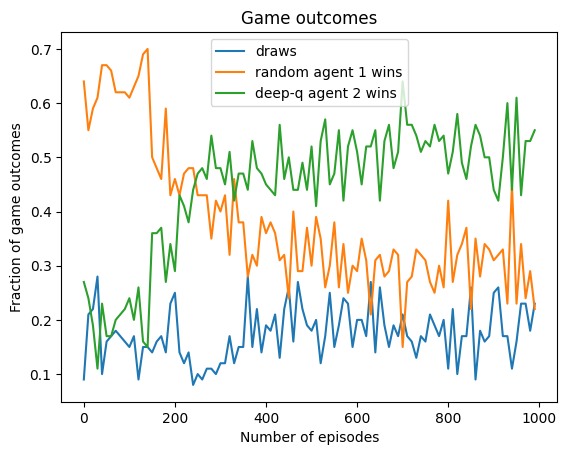

In [15]:
config = dict(base_config)
config["n_episode"]         = 1000
config["n_eval"]            = 100
config["eval_freq"]         = 10
config["train_freq"]        = 1
config["exploration"]       = 0.8
config["exploration_decay"] = 1-1e-3
config["learning_rate"]     = 1e-3
config["batch_size"]        = 512

agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
agent2 = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

# Define the Q-Network
agent2.online_model = build_dueling_dqn_model(agent2.input_shape, agent2.n_actions)
agent2.target_model = agent2.online_model

# Compile the model
agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

_ = training_manager.run_training(config, agents=[agent1, agent2])

Clearly, the duelling architecture learns more slowly and seems to perform worse with the current settings.  

## Finally, let us check whether adding convolutional layers can improve the performance of the model

In [21]:
# Define the Dueling DQN model
def build_convolutional_dqn_model(input_shape, num_actions):
    # Input layer
    inputs = tf.keras.layers.Input(shape=input_shape, name='input_state')
    # Shared layers for both the value and advantage streams
    conv_layer1   = tf.keras.layers.Conv2D(128, (3, 3), data_format="channels_last", activation='relu', padding="SAME")(inputs)
    conv_layer2   = tf.keras.layers.Conv2D(128, (3, 3), data_format="channels_last", activation='relu', padding="SAME")(conv_layer1)
    conv_layer3   = tf.keras.layers.Conv2D(64, (3, 3),  data_format="channels_last", activation='relu', padding="SAME")(conv_layer2)
    flattened     = tf.keras.layers.Flatten()(conv_layer3)
    hidden_layer  = tf.keras.layers.Dense(128, activation='relu')(flattened)
    outputs       = tf.keras.layers.Dense(num_actions, activation='linear')(hidden_layer)
    # Create the model
    return models.Model(inputs=inputs, outputs=outputs)

100%|██████████| 1000/1000 [23:32<00:00,  1.41s/it]


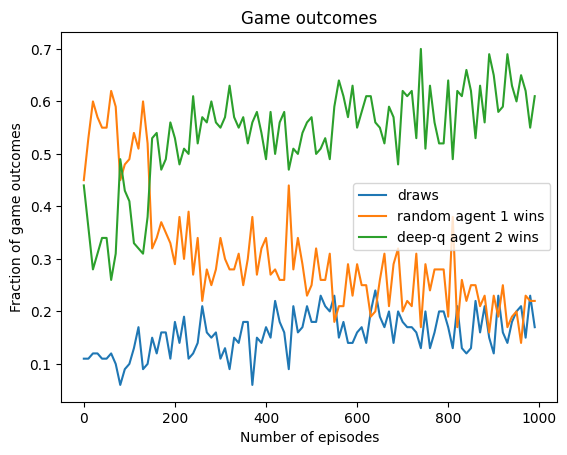

In [22]:
config = dict(base_config)
config["n_episode"]         = 1000
config["n_eval"]            = 100
config["eval_freq"]         = 10
config["train_freq"]        = 1
config["exploration"]       = 0.8
config["exploration_decay"] = 1-1e-3
config["learning_rate"]     = 1e-3
config["batch_size"]        = 512

agent1 = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
agent2 = agent_deep_q.ConvolutionalDeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

# Define the Q-Network
agent2.online_model = build_convolutional_dqn_model(agent2.input_shape, agent2.n_actions)
agent2.target_model = agent2.online_model

# Compile the model
agent2.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent2.learning_rate), loss='mse')

_ = training_manager.run_training(config, agents=[agent1, agent2])

The performance of the convolutional approach is not satisfying yet. But again, it may be that we need a larger number of training episodes. I will get back to the convolutional and dueling architectures and fine-tune them.
Other modifications, that I would like to investigate are batch normalisation, different optimisers, a scheme with an adaptive learning rate, pretraining, prioritised experience replay and deep learning from demonstrations.